# Stage 08 — Exploratory Data Analysis (EDA)

Goals:
- Summarize & visualize distributions and relationships
- Interpret trends/anomalies to inform modeling
- Document insights and assumptions clearly

## 0. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# Helper display
def title(msg):
    print('\n' + '='*len(msg))
    print(msg)
    print('='*len(msg))

## 1. Synthetic Data Generator (Reproducible)
No external CSVs required. This mimics a small financial-behavior dataset with both numeric and categorical variables and a time component.

In [2]:
n = 180  # ~6 months of daily data
dates = pd.date_range('2021-01-01', periods=n, freq='D')

regions = np.random.choice(['North','South','East','West'], size=n, p=[0.25,0.25,0.30,0.20])
age = np.random.normal(40, 8, size=n).clip(22, 70)
income = np.random.lognormal(mean=10.6, sigma=0.3, size=n)  # lognormal skew
transactions = np.random.poisson(lam=3, size=n) + (np.random.rand(n) < 0.05).astype(int)*8  # rare spikes
base_spend = (income * (0.0015 + 0.00002*(age-40)) + transactions*20)
noise = np.random.normal(0, 50, size=n)
spend = (base_spend + noise).clip(0)

# Assemble
df = pd.DataFrame({
    'date': dates,
    'region': regions,
    'age': age.round(1),
    'income': income.round(2),
    'transactions': transactions,
    'spend': spend.round(2)
})

# Inject missingness and outliers
df.loc[np.random.choice(df.index, size=6, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, size=4, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, size=2, replace=False), 'transactions'] = df['transactions'].max() + 15  # extreme outliers

df.head()

date region   age    income  transactions   spend
0 2021-01-01   West  51.4  27214.24             0    0.00
1 2021-01-02   West  47.4  33190.73             2   80.65
2 2021-01-03   West  35.9  46656.64             3  224.53
3 2021-01-04   East  38.6  42238.82             2  138.80
4 2021-01-05  North  32.7  74158.41             0   25.80

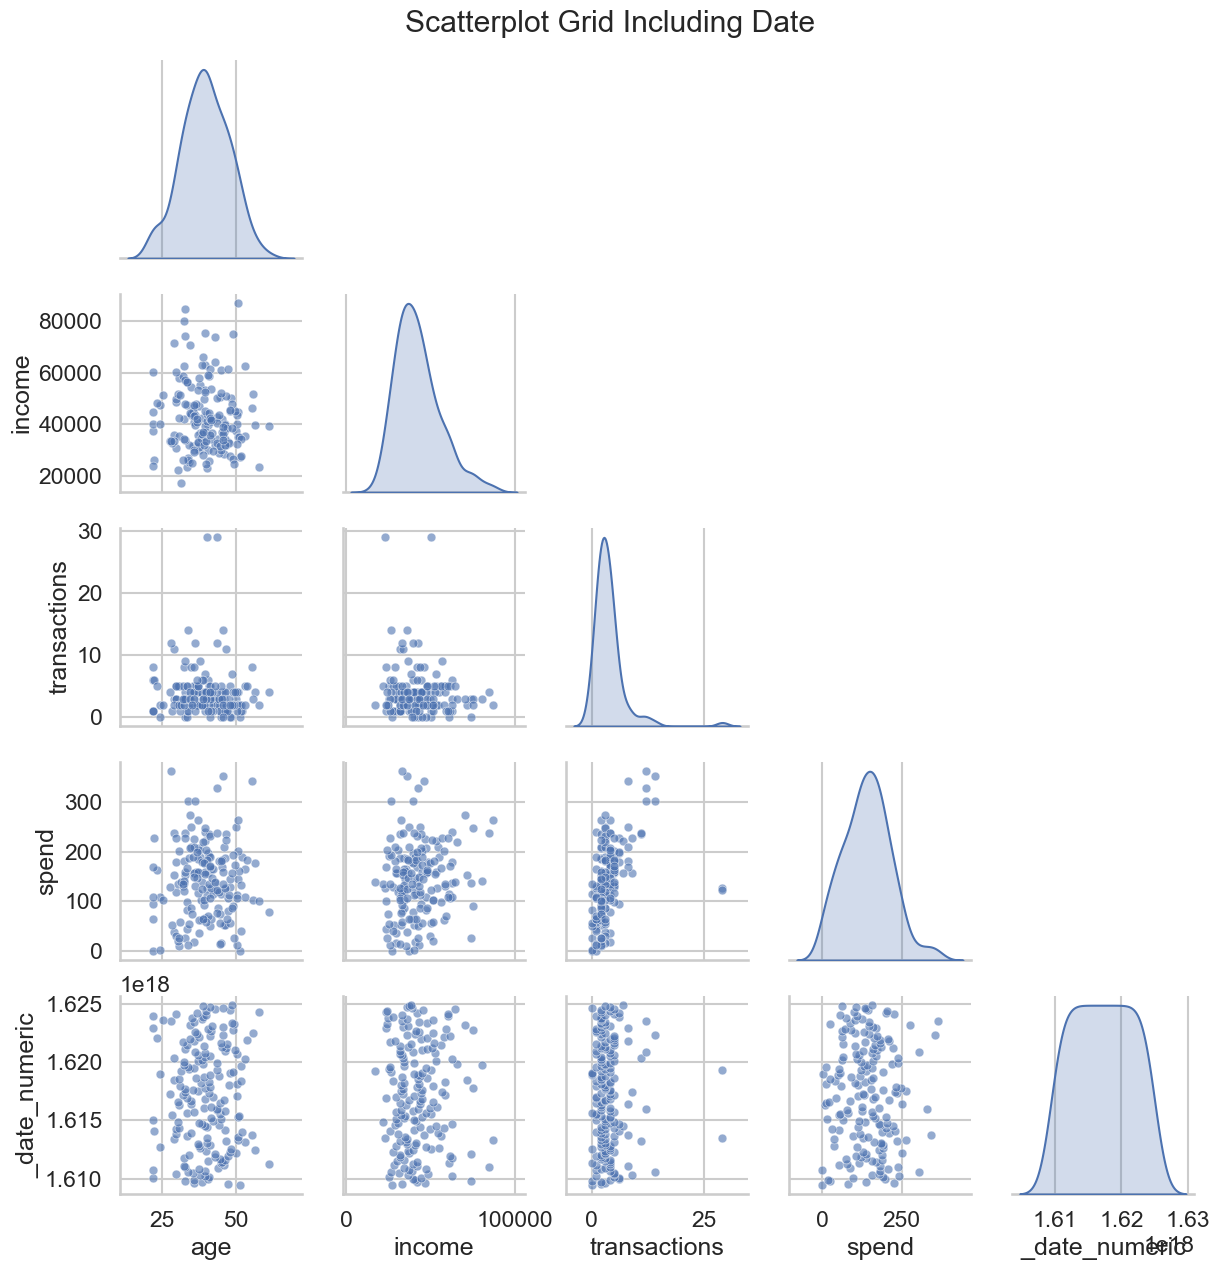

In [3]:
# --- Pair Plot Including Index for Time Context ---

# Temporarily add numeric index for plotting
df_plot = df.copy()
if 'date' in df_plot.columns:
    df_plot['_date_numeric'] = pd.to_numeric(pd.to_datetime(df_plot['date']))

# Select numeric columns
numeric_cols = df_plot.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    # Use corner=True to avoid redundant plots
    g = sns.pairplot(
        df_plot[numeric_cols], 
        diag_kind='kde', 
        corner=True,
        plot_kws={'alpha':0.6, 's':40}  # slight transparency and point size
    )
    
    # Remove KDE on diagonal for the _date_numeric column
    # for i, var in enumerate(g.diag_names):
    #     if var == '_date_numeric':
    #         g.diag_axes[i].cla()  # clear the diagonal
    #         g.diag_axes[i].text(0.5, 0.5, 'Date', ha='center', va='center')
    #         g.diag_axes[i].set_xticks([])
    #         g.diag_axes[i].set_yticks([])
    
    plt.suptitle("Scatterplot Grid Including Date", y=1.02)
    plt.show()
else:
    print("Not enough numeric columns for a scatterplot grid. Add more numeric features to see pair plots.")


## 2. First Look: Structure & Sanity Checks

In [4]:
title('df.info()')
df.info()
title('Head & Tail')
display(df.head(3))
display(df.tail(3))
title('Missingness counts')
df.isna().sum()


df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          180 non-null    datetime64[ns]
 1   region        180 non-null    object        
 2   age           180 non-null    float64       
 3   income        174 non-null    float64       
 4   transactions  180 non-null    int64         
 5   spend         176 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 8.6+ KB

Head & Tail


date region   age    income  transactions   spend
0 2021-01-01   West  51.4  27214.24             0    0.00
1 2021-01-02   West  47.4  33190.73             2   80.65
2 2021-01-03   West  35.9  46656.64             3  224.53

date region   age    income  transactions   spend
177 2021-06-27  North  41.1  35894.34             4  106.56
178 2021-06-28   East  38.8  37027.03             3   63.91
179 2021-06-29   West  48.7  38398.22             7  156.45


Missingness counts


date            0
region          0
age             0
income          6
transactions    0
spend           4
dtype: int64

In [5]:
title('Descriptive statistics')
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc


Descriptive statistics


count          mean           std       min         25%  \
age           180.0     39.630556      7.936867     22.00     34.2750   
income        174.0  42509.641264  13209.421297  17060.87  33192.4250   
transactions  180.0      3.777778      3.704980      0.00      2.0000   
spend         176.0    141.494943     73.718867      0.00     89.3425   

                    50%         75%       max      skew   kurtosis  
age              39.500     45.3750     61.10 -0.029707  -0.244275  
income        40297.665  49780.3325  87052.40  0.917298   0.770198  
transactions      3.000      4.0000     29.00  3.997703  22.562356  
spend           138.935    187.7425    362.51  0.310919   0.099200

### Notes
- `income` is lognormal (positively skewed): might consider log-transform later.
- `transactions` presents rare spikes: inspect outliers vs data quality.
- Missing values exist in `income` and `spend`: decide imputation strategy before modeling.

## 3. Univariate Visuals: Distributions & Outliers

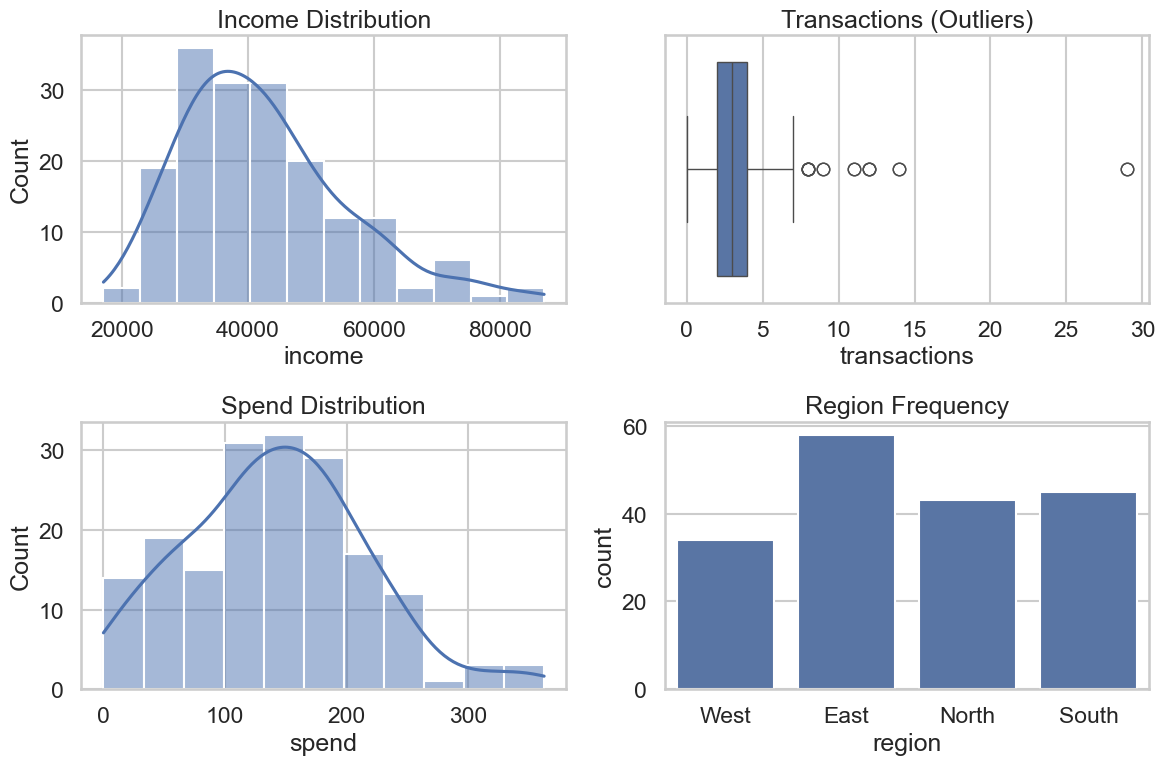

In [6]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
sns.histplot(df['income'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Income Distribution')
sns.boxplot(x=df['transactions'], ax=axes[0,1])
axes[0,1].set_title('Transactions (Outliers)')
sns.histplot(df['spend'], kde=True, ax=axes[1,0])
axes[1,0].set_title('Spend Distribution')
sns.countplot(x=df['region'], ax=axes[1,1])
axes[1,1].set_title('Region Frequency')
plt.tight_layout()
plt.show()

## 4. Bivariate Visuals: Relationships

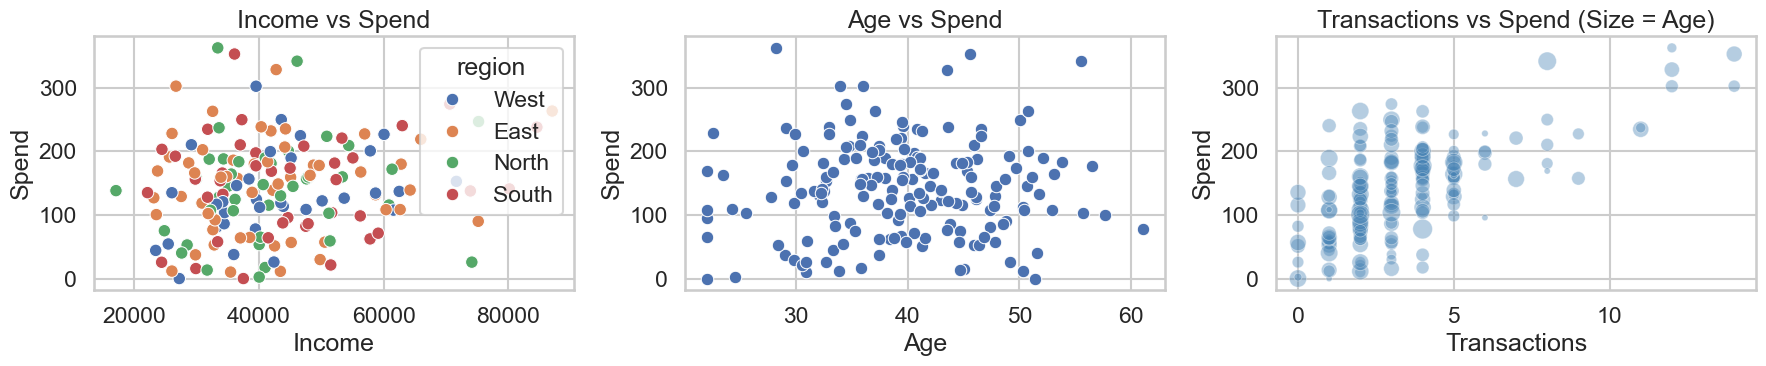

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Remove outliers in 'transactions'
df_filtered = df[df['transactions'] <= df['transactions'].quantile(0.99)]

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Income vs Spend
sns.scatterplot(data=df, x='income', y='spend', hue='region', ax=axes[0])
axes[0].set_title('Income vs Spend')
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Spend')

# Plot 2: Age vs Spend
sns.scatterplot(data=df, x='age', y='spend', ax=axes[1])
axes[1].set_title('Age vs Spend')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Spend')

# Plot 3: Transactions vs Spend — one color, transparency, size by age
sns.scatterplot(
    data=df_filtered,
    x='transactions', y='spend',
    size='age', sizes=(20, 200),  # scale bubble sizes
    color='steelblue', alpha=0.4, ax=axes[2], legend=False
)
axes[2].set_title('Transactions vs Spend (Size = Age)')
axes[2].set_xlabel('Transactions')
axes[2].set_ylabel('Spend')

plt.tight_layout()
plt.show()


## 5. Time Series Glance

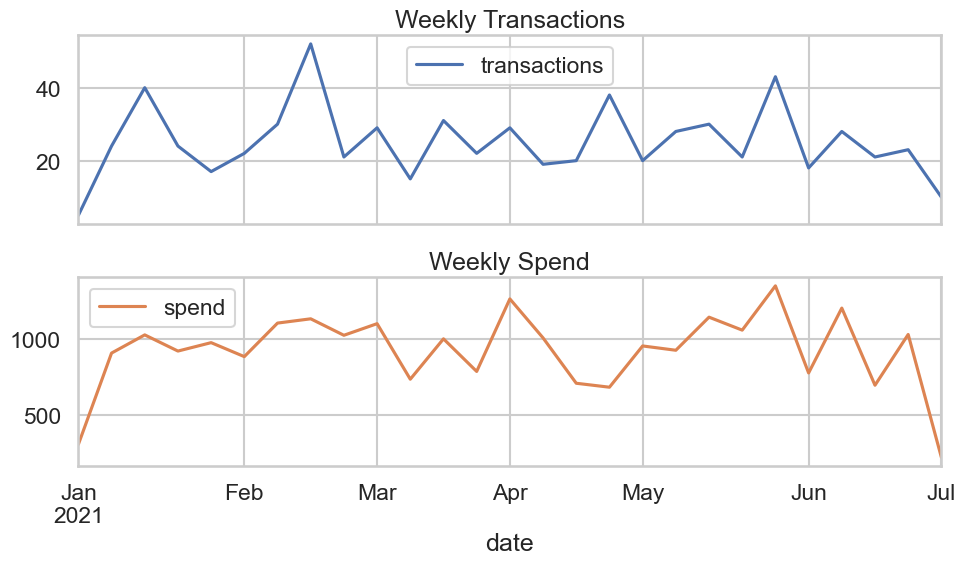

In [8]:
daily = df.set_index('date')[['transactions','spend']].resample('W').sum()
daily.plot(subplots=True, figsize=(10,6), title=['Weekly Transactions','Weekly Spend'])
plt.tight_layout()
plt.show()

## 6. Multi-Granularity Time-Series Grid with Rolling & Cumulative

In [17]:
# Setup (imports, constants)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducibility
date_range = pd.date_range(start='2021-01-01', end='2024-12-31', freq='D')
n_days = len(date_range)


In [18]:
# Generate Additive Data
def generate_additive_data():
    # Base trends
    spend_trend = np.linspace(100, 500, n_days)
    transactions_trend = np.linspace(50, 150, n_days)
    visits_trend = np.linspace(200, 300, n_days)

    # Seasonality (additive)
    seasonality = 30 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)

    # Noise (additive)
    noise_spend = np.random.normal(0, 20, n_days)
    noise_transactions = np.random.normal(0, 10, n_days)
    noise_visits = np.random.normal(0, 15, n_days)

    # Construct additive data
    df_add = pd.DataFrame({
        'date': date_range,
        'spend': spend_trend + seasonality + noise_spend,
        'transactions': transactions_trend + 0.5 * seasonality + noise_transactions,
        'visits': visits_trend + 0.3 * seasonality + noise_visits
    })
    return df_add


In [19]:
# Generate Multiplicative Data
def generate_multiplicative_data():
    # Base trends (must be positive)
    spend_trend = np.linspace(100, 500, n_days)
    transactions_trend = np.linspace(50, 150, n_days)
    visits_trend = np.linspace(200, 300, n_days)

    # Seasonality factors (multiplicative, oscillate around 1)
    seasonality_spend = 1 + 0.3 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)
    seasonality_transactions = 1 + 0.15 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)
    seasonality_visits = 1 + 0.1 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)

    # Noise factors (multiplicative, mean=1)
    noise_spend = np.random.normal(1, 0.1, n_days)
    noise_transactions = np.random.normal(1, 0.1, n_days)
    noise_visits = np.random.normal(1, 0.1, n_days)

    # Construct multiplicative data
    df_mul = pd.DataFrame({
        'date': date_range,
        'spend': spend_trend * seasonality_spend * noise_spend,
        'transactions': transactions_trend * seasonality_transactions * noise_transactions,
        'visits': visits_trend * seasonality_visits * noise_visits
    })
    return df_mul


## Time Series Simulation: Additive vs Multiplicative

We can simulate time series data with different components (Trend, Monthly, Quarterly, Yearly, Noise).  

- **Additive model**: Each component is added together. The total value at any time is the sum of its components.  
- **Multiplicative model**: Each component multiplies the base value. Growth and seasonal effects scale with the series level.  

Use the toggle below to switch between additive and multiplicative simulations for live exploration.


In [20]:
# Set this to either 'additive' or 'multiplicative' to pick your dataset
data_choice = 'multiplicative'  # or 'additive'

if data_choice == 'additive':
    df2 = generate_additive_data()
elif data_choice == 'multiplicative':
    df2 = generate_multiplicative_data()
else:
    raise ValueError("Invalid data_choice: use 'additive' or 'multiplicative'")

print(f"Using {data_choice} dataset with shape: {df2.shape}")


Using multiplicative dataset with shape: (1461, 4)


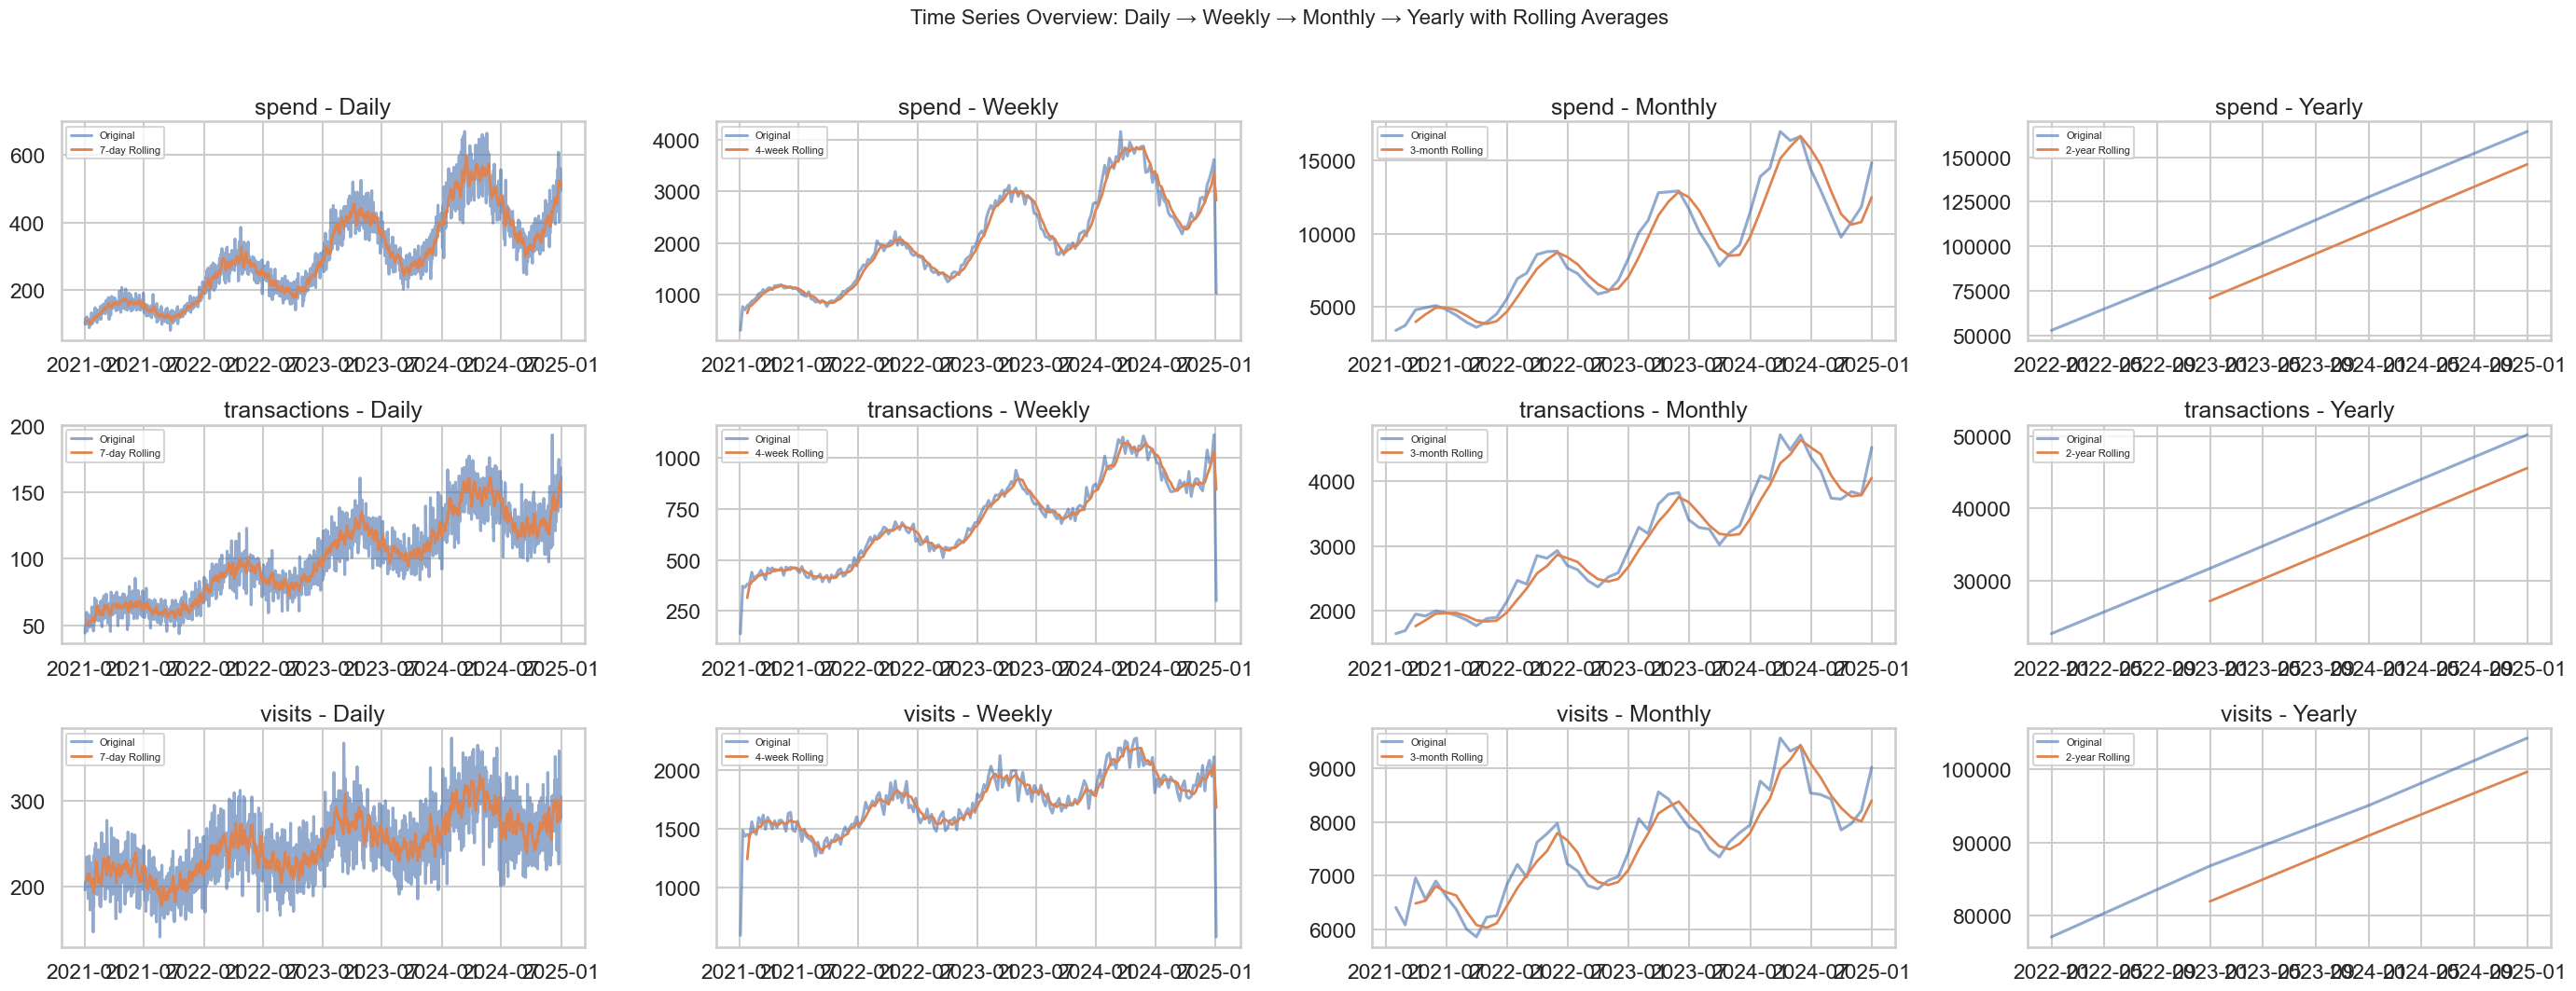

In [21]:
# Plotting Code
# Prepare data for plotting
ts_df = df2.copy()
ts_df['date'] = pd.to_datetime(ts_df['date'])
ts_df.set_index('date', inplace=True)

numeric_cols = ts_df.select_dtypes(include=np.number).columns.tolist()

daily = ts_df[numeric_cols]
weekly = daily.resample('W').sum()
monthly = daily.resample('ME').sum()
yearly = daily.resample('YE').sum()

daily_roll = daily.rolling(window=7).mean()
weekly_roll = weekly.rolling(window=4).mean()
monthly_roll = monthly.rolling(window=3).mean()
yearly_roll = yearly.rolling(window=2).mean()

fig, axes = plt.subplots(len(numeric_cols), 4, figsize=(28, 3.5 * len(numeric_cols)))
fig.suptitle("Time Series Overview: Daily → Weekly → Monthly → Yearly with Rolling Averages", fontsize=16, y=1.02)

if len(numeric_cols) == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(numeric_cols):
    axes[i, 0].plot(daily.index, daily[col], label='Original', alpha=0.6)
    axes[i, 0].plot(daily_roll.index, daily_roll[col], label='7-day Rolling', linewidth=2)
    axes[i, 0].set_title(f'{col} - Daily')
    axes[i, 0].legend(loc='upper left', fontsize=8)

    axes[i, 1].plot(weekly.index, weekly[col], label='Original', alpha=0.6)
    axes[i, 1].plot(weekly_roll.index, weekly_roll[col], label='4-week Rolling', linewidth=2)
    axes[i, 1].set_title(f'{col} - Weekly')
    axes[i, 1].legend(loc='upper left', fontsize=8)

    axes[i, 2].plot(monthly.index, monthly[col], label='Original', alpha=0.6)
    axes[i, 2].plot(monthly_roll.index, monthly_roll[col], label='3-month Rolling', linewidth=2)
    axes[i, 2].set_title(f'{col} - Monthly')
    axes[i, 2].legend(loc='upper left', fontsize=8)

    axes[i, 3].plot(yearly.index, yearly[col], label='Original', alpha=0.6)
    axes[i, 3].plot(yearly_roll.index, yearly_roll[col], label='2-year Rolling', linewidth=2)
    axes[i, 3].set_title(f'{col} - Yearly')
    axes[i, 3].legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

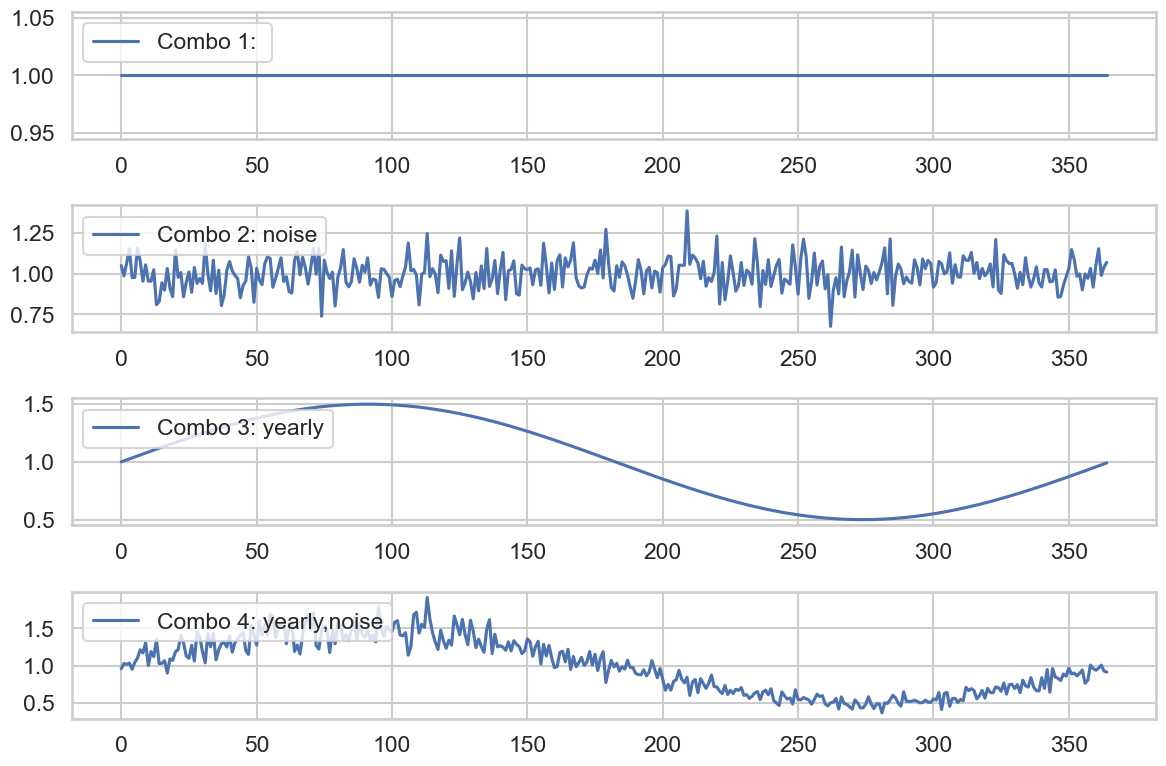

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

np.random.seed(42)
n_days = 365

# Component generators
def trend(t): return 0.05*t
def monthly_cycle(t): return 2*np.sin(2*np.pi*t/30)
def quarterly_cycle(t): return 3*np.sin(2*np.pi*t/90)
def yearly_cycle(t): return 5*np.sin(2*np.pi*t/365)
def noise(t): return np.random.normal(0,1,len(t))

components = {
    'trend': trend,
    'monthly': monthly_cycle,
    'quarterly': quarterly_cycle,
    'yearly': yearly_cycle,
    'noise': noise
}

component_names = list(components.keys())
n_combos = 4  # number of combinations to demo
combos = list(product([0,1], repeat=len(component_names)))[:n_combos]

additive = False  # toggle: True=Additive, False=Multiplicative

plt.figure(figsize=(12,8))
t = np.arange(n_days)

for i, combo_mask in enumerate(combos,1):
    if additive:
        series = np.zeros(n_days)
        for include, cname in zip(combo_mask, component_names):
            if include:
                series += components[cname](t)
    else:
        series = np.ones(n_days)
        for include, cname in zip(combo_mask, component_names):
            if include:
                series *= (1 + components[cname](t)/10)  # scale to avoid explosion
    plt.subplot(n_combos,1,i)
    plt.plot(t, series, label=f'Combo {i}: ' + ','.join([c for c, inc in zip(component_names, combo_mask) if inc]))
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## 7. Correlation Matrix (Optional but Recommended)

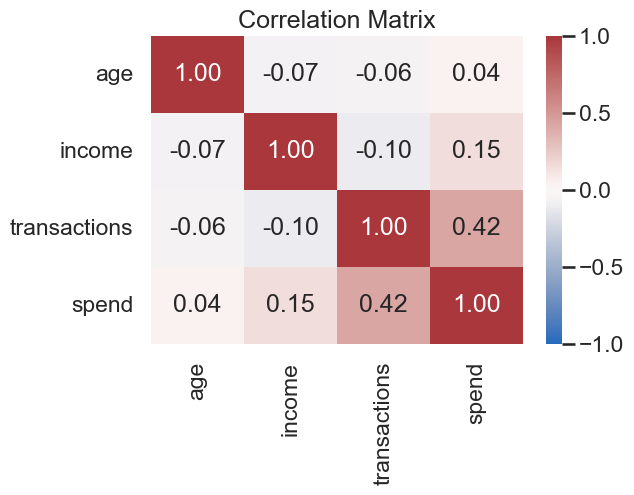

age    income  transactions     spend
age           1.000000 -0.066301     -0.062386  0.040151
income       -0.066301  1.000000     -0.102172  0.152572
transactions -0.062386 -0.102172      1.000000  0.423752
spend         0.040151  0.152572      0.423752  1.000000

In [22]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

## 8. Reusable Helper: `eda_summary(df)`

In [24]:
def eda_summary(df: pd.DataFrame, numeric_cols=None):
    """Return a dict with quick profiling stats and basic missingness.
    numeric_cols: optional list to limit numeric profiling.
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = {}
    out['shape'] = df.shape
    out['dtypes'] = df.dtypes.to_dict()
    out['missing'] = df.isna().sum().to_dict()
    profile = df[numeric_cols].describe().T
    profile['skew'] = [skew(df[c].dropna()) for c in profile.index]
    profile['kurtosis'] = [kurtosis(df[c].dropna()) for c in profile.index]
    out['numeric_profile'] = profile
    return out

summary = eda_summary(df)
summary['shape'], list(summary['dtypes'].items())[:3]

((180, 6),
 [('date', dtype('<M8[ns]')),
  ('region', dtype('O')),
  ('age', dtype('float64'))])

## 9. “So What?”: Insights & Assumptions for the data above
- **Skew**: `income` and `spend` are right-skewed → consider log transforms for linear models.
- **Outliers**: transactions show spikes → verify data quality; maybe winsorize.
- **Relationships**: positive `income–spend`; check nonlinearity (might motivate interaction terms later).
- **Missingness**: imputation strategy required before modeling.

**Next step**: translate these into feature hypotheses (ratios, lags, logs) in the Feature Engineering stage.

## 10. “So What?”: Insights & Assumptions (General)

After exploring distributions, relationships, and trends, we can summarize potential insights and assumptions:

| Insight / Finding | Assumption | Example Actions / Next Steps |
|------------------|------------|------------------------------|
| **Missing values** | Some entries in `column0`, `column1`, etc. might be missing at random or systematically | Impute (mean/median/mode), forward-fill, or drop rows/columns; optionally flag missingness as a feature |
| **Skewed distribution** | Variables like `column0` and `column1` may be right- or left-skewed | Apply log-transform or other normalization if needed for modeling |
| **Outliers** | Extreme values in `column0` or `column1` may be rare events or errors | Cap/winsorize, remove, or leave if using robust models |
| **Correlation between columns** | Strong correlation between columns might indicate redundancy | Consider dropping one column, applying PCA, or using regularized models |
| **Trends / time patterns** | `column1` or `column2` may show weekly/monthly/yearly trends | Aggregate by time period, create lagged or rolling features for forecasting or modeling |
| **Relationships between variables** | `column0` vs `column1` relationships may reveal interactions | Consider interaction terms, polynomial features, or segmented models |
| **Feature engineering opportunities** | Derived features can capture additional signal | Create ratios, differences, rolling averages, or binary thresholds |
| **Data quality / anomalies** | Unusual patterns in `column0` or `column1` may indicate entry errors | Verify with domain knowledge and clean or remove if necessary |

**Next Steps:** Use these observations to guide **feature engineering**, **data cleaning**, and **modeling decisions** in subsequent stages.


## 11. (Optional) Save Notebook Naming Pattern
Use: `notebooks/eda_<team>.ipynb`. (Skip actual disk I/O in this demo.)